# Computer Vision Project

DOMAIN: Entertainment

CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene.

PROJECT OBJECTIVE: To build a face detection system

In [48]:
# Import required packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import model_selection
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import warnings
import cv2
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras import optimizers
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, Activation, BatchNormalization, SpatialDropout2D
from tensorflow.keras.applications.mobilenet import MobileNet
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
from zipfile import ZipFile
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
import random
from tensorflow.keras import backend
from glob import glob
import os

Import and read data from the 'images.npy' file

In [2]:
# modify the default parameters of np.load
np_load1 = np.load
np.load = lambda *a,**k: np_load1(*a, allow_pickle = True, **k)

# Import and read data
data = np.load('images.npy')

In [3]:
data.shape

(409, 2)

In [4]:
data[0]

array([array([[[42, 37, 34],
               [56, 51, 48],
               [71, 66, 63],
               ...,
               [23, 33, 34],
               [26, 36, 37],
               [28, 38, 39]],

              [[40, 35, 32],
               [51, 46, 43],
               [64, 59, 56],
               ...,
               [27, 36, 35],
               [24, 33, 32],
               [26, 35, 34]],

              [[43, 38, 35],
               [51, 46, 43],
               [61, 56, 53],
               ...,
               [28, 30, 27],
               [33, 35, 32],
               [35, 37, 34]],

              ...,

              [[56, 47, 40],
               [57, 48, 41],
               [61, 52, 45],
               ...,
               [67, 48, 42],
               [55, 35, 28],
               [60, 40, 33]],

              [[53, 44, 37],
               [54, 45, 38],
               [57, 48, 41],
               ...,
               [59, 40, 34],
               [60, 40, 33],
               [54, 34, 27]],



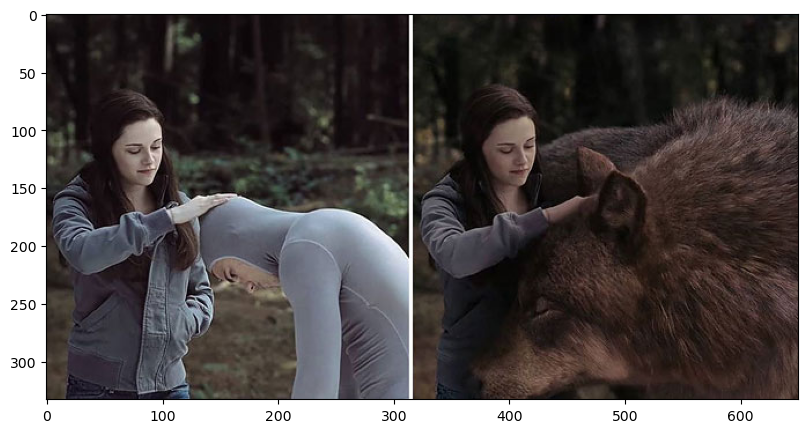

In [5]:
fig = plt.figure(figsize = (12, 5))
ax = fig.add_subplot(1, 1, 1)
plt.imshow(data[0][0])
plt.show()

In [6]:
print(data[0][1])

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063}, {'x': 0.1723076923076923, 'y': 0.45345345345345345}], 'imageWidth': 650, 'imageHeight': 333}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913}, {'x': 0.6584615384615384, 'y': 0.46846846846846846}], 'imageWidth': 650, 'imageHeight': 333}]


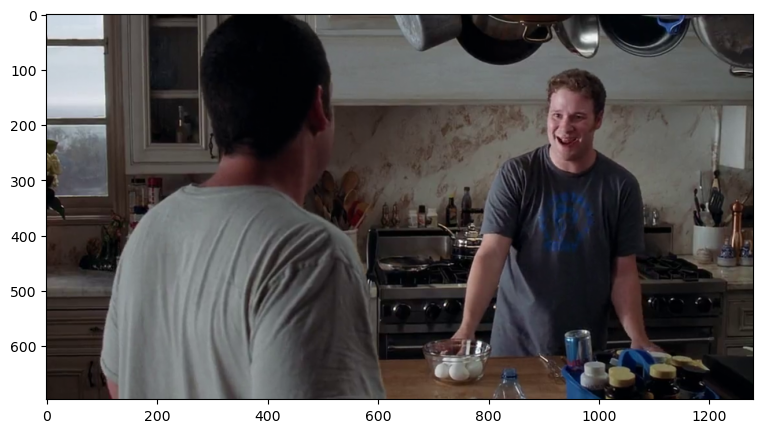

In [7]:
fig = plt.figure(figsize = (12, 5))
ax = fig.add_subplot(1, 1, 1)
plt.imshow(data[1][0])
plt.show()

In [8]:
print(data[1][1])

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.7053087757313109, 'y': 0.23260437375745527}, {'x': 0.7692307692307693, 'y': 0.36182902584493043}], 'imageWidth': 1280, 'imageHeight': 697}]


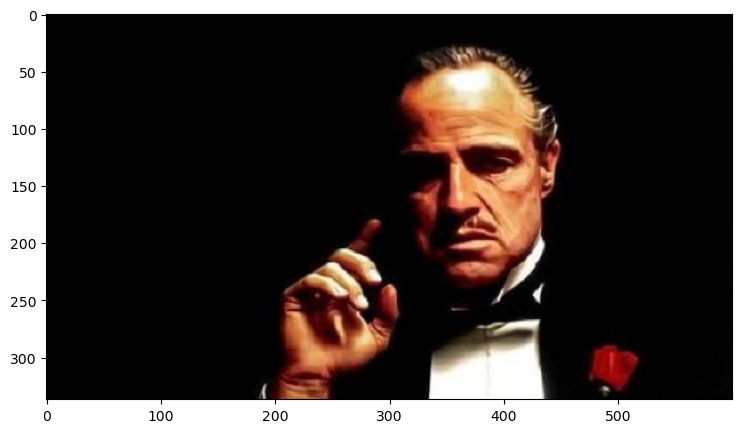

In [9]:
fig = plt.figure(figsize = (12, 5))
ax = fig.add_subplot(1, 1, 1)
plt.imshow(data[10][0])
plt.show()

In [10]:
print(data[10][1])

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.48, 'y': 0.10385756676557864}, {'x': 0.7716666666666666, 'y': 0.6795252225519288}], 'imageWidth': 600, 'imageHeight': 337}]


Split the data into Features(X) & labels(Y). Unify shape of all the images

Set image dimensions to unify shape of all images

In [11]:
IMAGE_SIZE = 224
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

In [14]:
masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for i in range(data.shape[0]):
    image = data[i][0]
    image = cv2.resize(image, dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
    try:
        image = image[:, :, :3]
    except:
        continue
    X[i] = preprocess_input(np.array(image, dtype = np.float32))
    for j in data[i][1]:
        x1 = int(j['points'][0]['x'] * IMAGE_WIDTH)
        x2 = int(j['points'][1]['x'] * IMAGE_WIDTH)
        y1 = int(j['points'][0]['y'] * IMAGE_HEIGHT)
        y2 = int(j['points'][1]['y'] * IMAGE_HEIGHT)
        masks[i][y1:y2, x1:x2] = 1

In [15]:
X.shape

(409, 224, 224, 3)

In [16]:
masks.shape

(409, 224, 224)

Select random image from the train data and display original image and masked image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


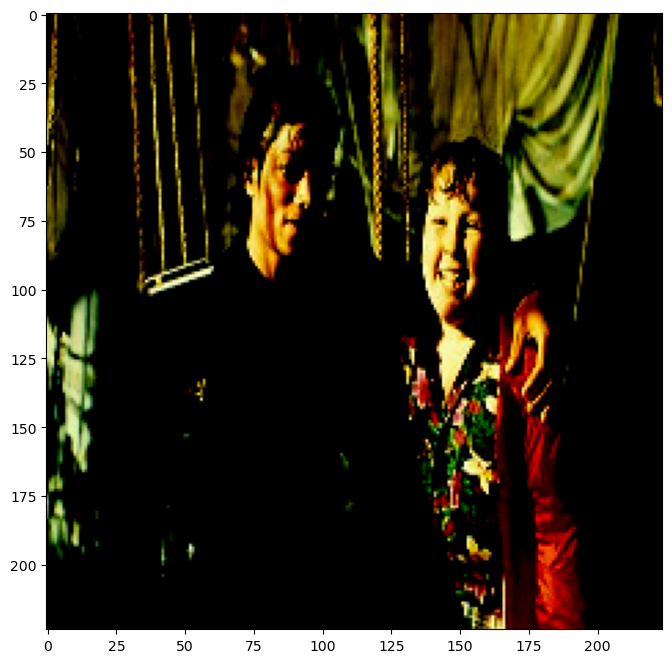

In [17]:
n = np.random.randint(0,409)
fig = plt.figure(figsize = (15, 8))
ax = fig.add_subplot(1, 1, 1)
plt.imshow(X[n])

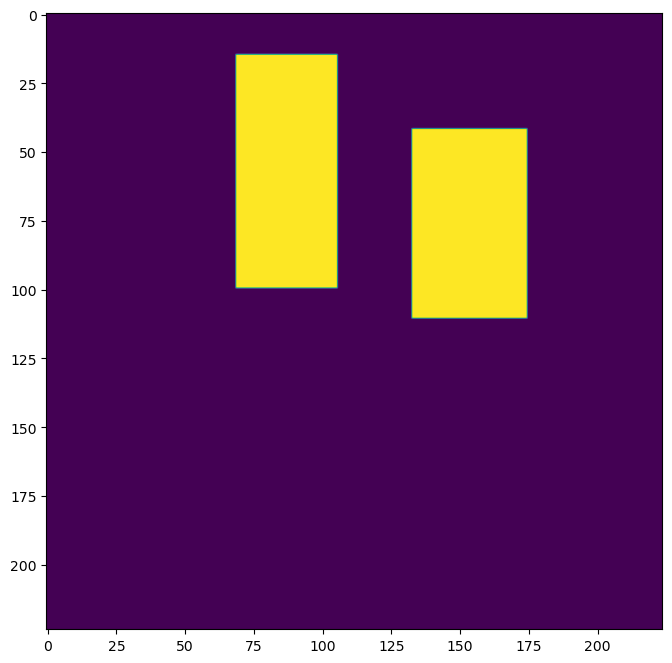

In [18]:
fig = plt.figure(figsize = (15, 8))
ax = fig.add_subplot(1, 1, 1)
plt.imshow(masks[n])

Split the data into train and test [400:9]

In [19]:
X_train, X_test, y_train, y_test = X[:400], X[400:], masks[:400], masks[400:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 224, 224, 3), (9, 224, 224, 3), (400, 224, 224), (9, 224, 224))

Design a face mask detection model

In [22]:
def conv_block(prevlayer, filters, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding = 'same', kernel_initializer = 'he_uniform', strides = strides)(prevlayer)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    return conv

def build_model(trainable = True):
    model = MobileNet(input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top = False, alpha = 1.0, weights = 'imagenet')
    for l in model.layers:
        l.trainable = trainable
    
    b1 = model.get_layer('conv_pw_13_relu').output
    b2 = model.get_layer('conv_pw_11_relu').output
    b3 = model.get_layer('conv_pw_5_relu').output
    b4 = model.get_layer('conv_pw_3_relu').output
    b5 = model.get_layer('conv_pw_1_relu').output
    
    up1 = Concatenate()([UpSampling2D()(b1), b2])
    conv6 = conv_block(up1, 256)
    conv6 = conv_block(conv6, 256)

    up2 = Concatenate()([UpSampling2D()(conv6), b3])
    conv7 = conv_block(up2, 256)
    conv7 = conv_block(conv7, 256)

    up3 = Concatenate()([UpSampling2D()(conv7), b4])
    conv8 = conv_block(up3, 192)
    conv8 = conv_block(conv8, 128)

    up4 = Concatenate()([UpSampling2D()(conv8), b5])
    conv9 = conv_block(up4, 96)
    conv9 = conv_block(conv9, 64)

    up5 = Concatenate()([UpSampling2D()(conv9), model.input])
    conv10 = conv_block(up5, 48)
    conv10 = conv_block(conv10, 32)
    conv10 = SpatialDropout2D(0.2)(conv10)
    
    x = Conv2D(1, (1, 1), activation = 'sigmoid')(conv10)
    x = Reshape((IMAGE_SIZE, IMAGE_SIZE))(x)
    return Model(inputs = model.input, outputs = x)

In [23]:
model = build_model(True)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                                                           

 on)                                                                                              
                                                                                                  
 conv_dw_5_relu (ReLU)          (None, 28, 28, 256)  0           ['conv_dw_5_bn[0][0]']           
                                                                                                  
 conv_pw_5 (Conv2D)             (None, 28, 28, 256)  65536       ['conv_dw_5_relu[0][0]']         
                                                                                                  
 conv_pw_5_bn (BatchNormalizati  (None, 28, 28, 256)  1024       ['conv_pw_5[0][0]']              
 on)                                                                                              
                                                                                                  
 conv_pw_5_relu (ReLU)          (None, 28, 28, 256)  0           ['conv_pw_5_bn[0][0]']           
          

 conv_dw_11 (DepthwiseConv2D)   (None, 14, 14, 512)  4608        ['conv_pw_10_relu[0][0]']        
                                                                                                  
 conv_dw_11_bn (BatchNormalizat  (None, 14, 14, 512)  2048       ['conv_dw_11[0][0]']             
 ion)                                                                                             
                                                                                                  
 conv_dw_11_relu (ReLU)         (None, 14, 14, 512)  0           ['conv_dw_11_bn[0][0]']          
                                                                                                  
 conv_pw_11 (Conv2D)            (None, 14, 14, 512)  262144      ['conv_dw_11_relu[0][0]']        
                                                                                                  
 conv_pw_11_bn (BatchNormalizat  (None, 14, 14, 512)  2048       ['conv_pw_11[0][0]']             
 ion)     

 up_sampling2d_7 (UpSampling2D)  (None, 56, 56, 256)  0          ['activation_3[0][0]']           
                                                                                                  
 concatenate_7 (Concatenate)    (None, 56, 56, 384)  0           ['up_sampling2d_7[0][0]',        
                                                                  'conv_pw_3_relu[0][0]']         
                                                                                                  
 conv2d_5 (Conv2D)              (None, 56, 56, 192)  663744      ['concatenate_7[0][0]']          
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 56, 56, 192)  768        ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activatio

Design your own Dice Coefficient and Loss function

In [24]:
def dice_coefficient(y_true, y_pred):
    n = 2 * tf.reduce_sum(y_true * y_pred)
    d = tf.reduce_sum(y_true + y_pred)

    return n / (d + tf.keras.backend.epsilon())

In [25]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [27]:
checkpoint = ModelCheckpoint('model_{loss:.2f}.h5', monitor = 'loss', verbose = 1, save_best_only = True, save_weights_only = True, mode = 'min', period = 1)
stop = EarlyStopping(monitor = 'loss', patience = 5, mode = 'min')
reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 5, min_lr = 1e-6, verbose = 1, mode = 'min')

In [28]:
adam = Adam(lr = 1e-3)
model.compile(loss = loss, optimizer = adam, metrics = [dice_coefficient])

In [29]:
model.fit(X_train, y_train, epochs = 3, batch_size = 64, callbacks = [checkpoint, reduce_lr, stop], validation_data = (X_test, y_test))

Epoch 1/3
7/7 [==============================] - ETA: 0s - loss: 1.6037 - dice_coefficient: 0.3800  
Epoch 1: loss improved from inf to 1.60367, saving model to model_1.60.h5
7/7 [==============================] - 854s 116s/step - loss: 1.6037 - dice_coefficient: 0.3800 - val_loss: 10.0875 - val_dice_coefficient: 0.2585 - lr: 0.0010
Epoch 2/3
7/7 [==============================] - ETA: 0s - loss: 0.9590 - dice_coefficient: 0.5186  
Epoch 2: loss improved from 1.60367 to 0.95901, saving model to model_0.96.h5
7/7 [==============================] - 824s 115s/step - loss: 0.9590 - dice_coefficient: 0.5186 - val_loss: 15.2466 - val_dice_coefficient: 0.1939 - lr: 0.0010
Epoch 3/3
7/7 [==============================] - ETA: 0s - loss: 0.7692 - dice_coefficient: 0.5830  
Epoch 3: loss improved from 0.95901 to 0.76920, saving model to model_0.77.h5
7/7 [==============================] - 829s 116s/step - loss: 0.7692 - dice_coefficient: 0.5830 - val_loss: 15.2519 - val_dice_coefficient: 0.1939 

Evaluate and share insights on performance of the model

In [30]:
model.evaluate(X_test, y_test, verbose = 1)

1/1 [==============================] - 4s 4s/step - loss: 15.2519 - dice_coefficient: 0.1939


[15.251937866210938, 0.19391345977783203]

Loss is quite high on the test set, indicating that the model is likely overfitting

Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image.

In [34]:
WEIGHTS_FILE = "model_0.43.h5"
l_model = build_model()
l_model.load_weights(WEIGHTS_FILE)
y_pred = l_model.predict(X_test, verbose = 1)

1/1 [==============================] - 7s 7s/step


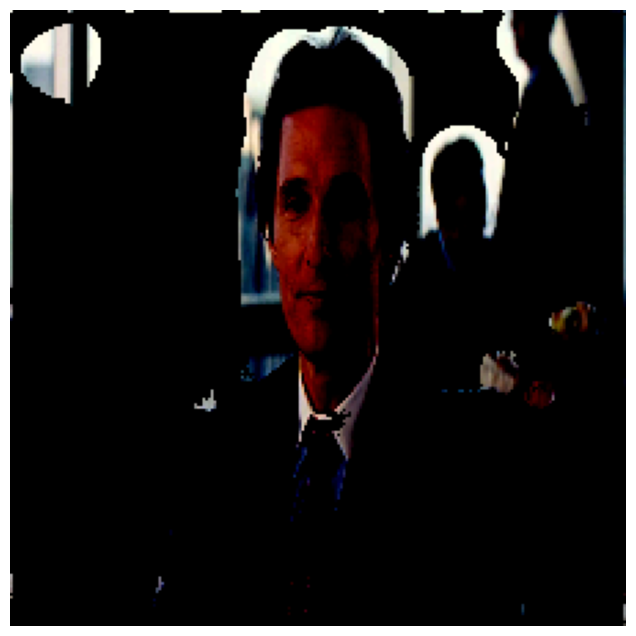

In [36]:
n = 3
image = cv2.resize(X_test[n], dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
pred_mask = cv2.resize(1.0*(y_pred[n] > 0.1), (IMAGE_WIDTH, IMAGE_HEIGHT))

img2 = image
img2[:,:,0] = pred_mask*image[:,:,0]
img2[:,:,1] = pred_mask*image[:,:,1]
img2[:,:,2] = pred_mask*image[:,:,2]
op_image = img2

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(op_image)

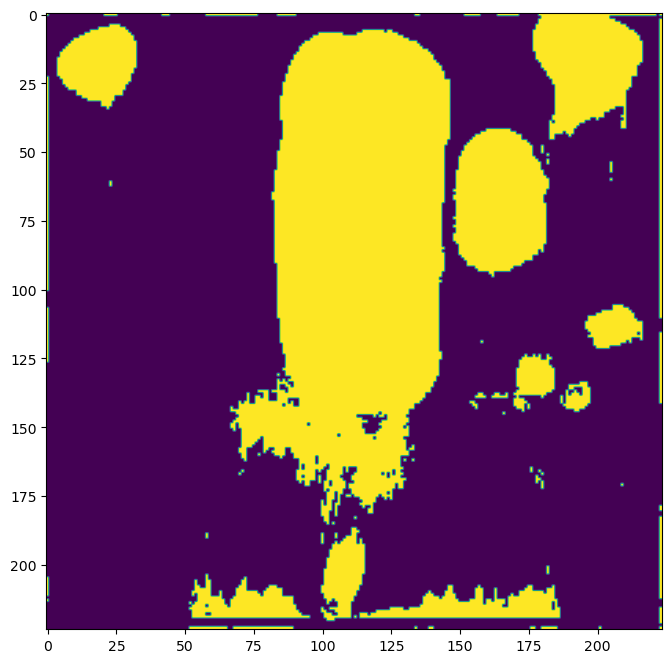

In [37]:
fig = plt.figure(figsize = (15, 8))
ax = fig.add_subplot(1, 1, 1)
plt.imshow(pred_mask, alpha = 1)

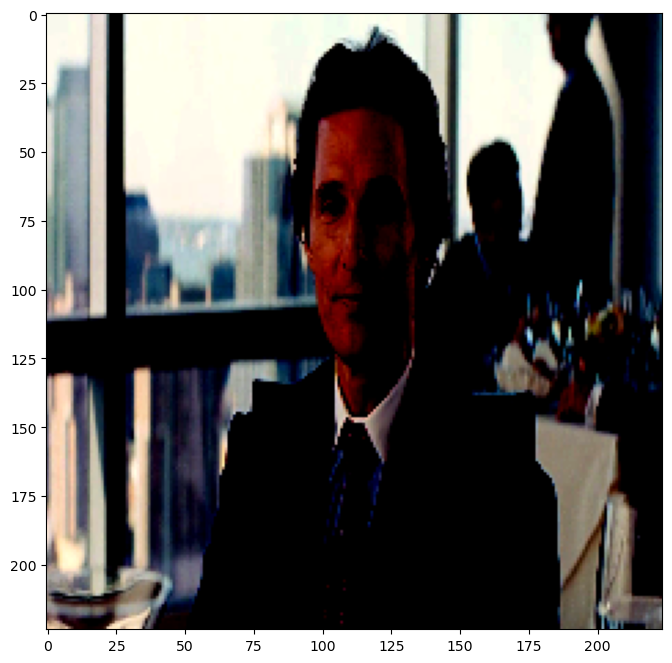

In [38]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(1, 1, 1)
plt.imshow(X_test[n])
plt.savefig('image.jpg')

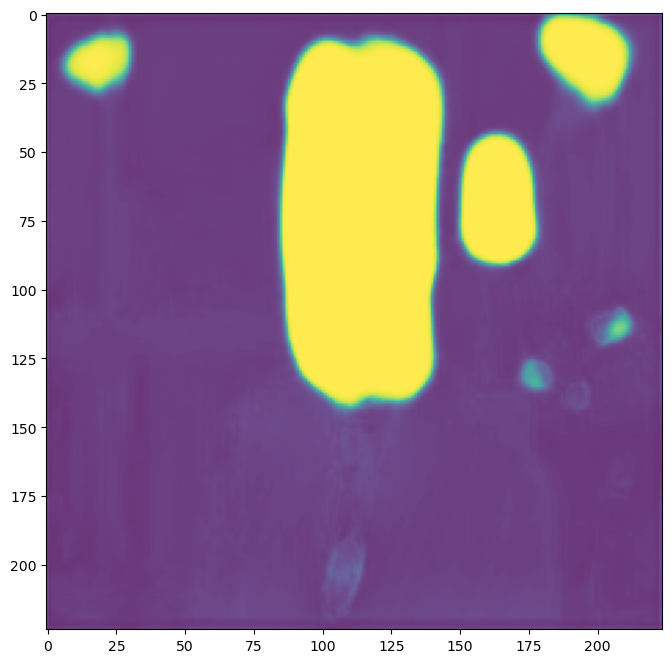

In [39]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(1, 1, 1)
plt.imshow(y_pred[n], alpha = 0.8)
plt.savefig('mask.jpg')

In [40]:
img = cv2.imread('image.jpg', 1)
mask = cv2.imread('mask.jpg', 1)
img = cv2.add(img, mask)
cv2.imshow('Image',img)
cv2.waitKey(0)

-1

# Part B

DOMAIN: Entertainment

CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene.
The data labelling is already done. Since there higher time complexity is involved in the

DATA DESCRIPTION: The dataset comprises of face images.

PROJECT OBJECTIVE: To create an image dataset to be used by AI team build an image classifier data. Profile images of people are given.

Read/import images from folder ‘training_images’

In [120]:
# import data
with ZipFile('training_images.zip', 'r') as zip:
    zip.extractall()

In [121]:
files = glob('C:/AIML/AIML/PGP/Computer Vision/Project/training_images/*.jpg')

In [123]:
images_b = []
labels_b = []
for file in files:
    imgb = cv2.imread(file)
    name = file.split('/')[-1]
    labels_b.append(name[len(name) - 14:])
    images_b.append(imgb)

In [124]:
labels_b[10]

'real_00011.jpg'

In [125]:
len(images_b)

1091

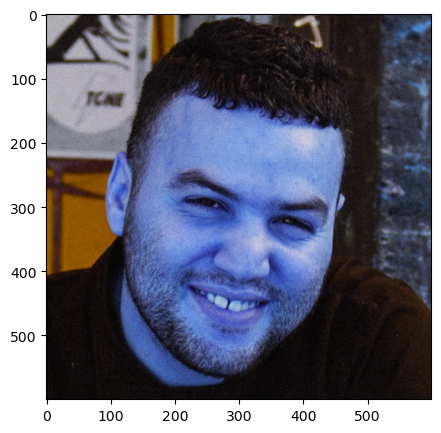

In [126]:
fig = plt.figure(figsize = (10, 5))
plt.imshow(images_b[3])

Loop through the images and detect faces present in the images, extract metadata of the faces and write into a DataFrame

In [147]:
df = pd.DataFrame(columns = ['x','y','w','h', 'Total_Faces', 'Image_Name'])
for k in range(0,len(images_b)):
    gray = cv2.cvtColor(images_b[k], cv2.COLOR_BGR2GRAY)
    face_detector=cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_detector.detectMultiScale(gray, 1.3, 5)
    x_c=[]
    y_c=[]
    w_c=[]
    h_c=[]
    numfaces=0
    for (x,y,w,h) in faces:
        cv2.rectangle(images_b[k],(x,y),(x+w,y+h),(0,255,0),2)
        x_c.append(x)
        y_c.append(y)
        w_c.append(w)
        h_c.append(h)
        numfaces=numfaces+1
    row = pd.Series([x_c,y_c,w_c,h_c,numfaces,labels_b[k]], index=df.columns)
    df = df.append(row,ignore_index=True)


C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipyker

C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipyker

C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipyker

C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipyker

C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipyker

C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipyker

C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipyker

C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipyker

C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipyker

C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipyker

C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipyker

C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipyker

C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipyker

C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipyker

C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipyker

C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipyker

C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipyker

C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipyker

C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipyker

C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipyker

C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipyker

C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipyker

C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipyker

C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipyker

C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipyker

C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipyker

C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipyker

C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipyker

C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipyker

C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipyker

C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_2128\3360707543.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row,ignore_index=True)
C:\Users\prash\AppData\Local\Temp\ipyker

In [148]:
print(df.shape)

(1091, 6)


In [149]:
df.iloc[0]

x                       [139]
y                       [123]
w                       [430]
h                       [430]
Total_Faces                 1
Image_Name     real_00001.jpg
Name: 0, dtype: object

In [150]:
df.iloc[100]

x                        [51]
y                        [61]
w                       [486]
h                       [486]
Total_Faces                 1
Image_Name     real_00101.jpg
Name: 100, dtype: object

Save the output Dataframe in .csv format.

In [151]:
df.to_csv('Face_Detection.csv')

# Part C

DOMAIN: Face Recognition

CONTEXT: Company X intends to build a face identification model to recognise human faces.

DATA DESCRIPTION: The dataset comprises of images and its mask where there is a human face.

PROJECT OBJECTIVE: Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken from 'Pinterest' and aligned using dlib library. Some data samples:

Unzip, read and Load data(‘PINS.zip’)

In [31]:
with ZipFile('PINS.zip', 'r') as zip:
    zip.extractall()

Write function to create metadata of the image

In [32]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 

Loop to iterate through each and every image and create metadata for all the images

In [33]:
def load_metadata(path):
    metadata = []
    exts = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
                exts.append(ext)
    return np.array(metadata), exts

In [41]:
metadata, ext = load_metadata('PINS')
labelsc = np.array([meta.name for meta in metadata])

In [42]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

Load sample image

In [43]:
n = np.random.randint(1, len(metadata))
img_path = metadata[n].image_path()
imgc = load_image(img_path)

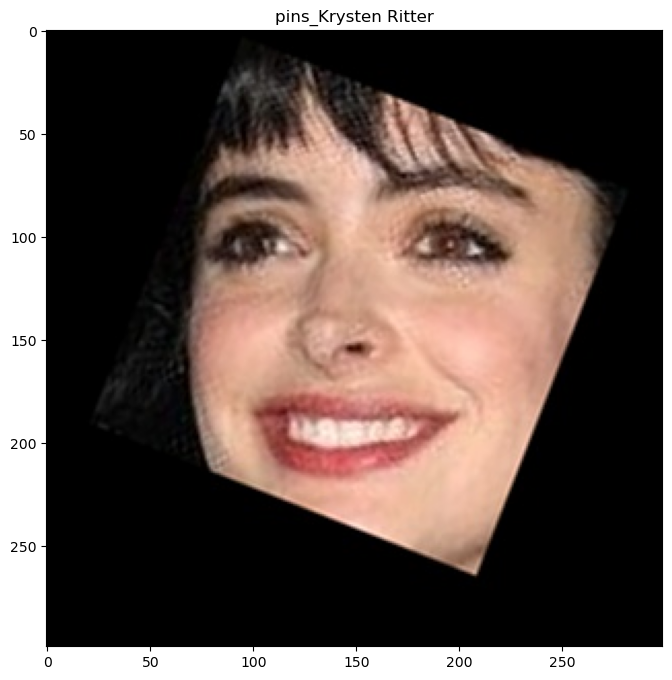

In [45]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_title(labelsc[n])
plt.imshow(imgc)

Generate Embeddings vectors on the each face in the dataset

VGG Face model

In [46]:
def vgg_face():
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape = (224, 224, 3)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides =(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Convolution2D(4096, (7, 7), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

Load the model

In [49]:
modelc = vgg_face()
modelc.load_weights('vgg_face_weights.h5')
print(modelc.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 226, 226, 3)      0         
 2D)                                                             
                                                                 
 conv2d_23 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 226, 226, 64)     0         
 ng2D)                                                           
                                                                 
 conv2d_24 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                        

In [50]:
vgg_face_descriptor = Model(inputs = modelc.layers[0].input, outputs = modelc.layers[-2].output)

Generate embeddings for each image in the dataset

In [51]:
img_path = metadata[0].image_path()
imgc = load_image(img_path)

In [52]:
imgc = (imgc / 255.).astype(np.float32)

In [53]:
imgc = cv2.resize(img, dsize = (224, 224))
print(img.shape)

(800, 1200, 3)


In [54]:
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(imgc, axis = 0))[0]
print(embedding_vector.shape)

1/1 [==============================] - 1s 923ms/step
(2622,)


In [55]:
embeddings = []
embeddings = np.zeros((metadata.shape[0], 2622))
for i, meta in enumerate(metadata):
    try:
        image = load_image(str(meta))
        image = (image/255.).astype(np.float32)
        image = cv2.resize(image, (224, 224))
        embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(image, axis = 0))[0]
    except:
        embeddings[i] = np.zeros(2622)

1/1 [==============================] - 1s 704ms/step


1/1 [==============================] - 1s 798ms/step


1/1 [==============================] - 0s 299ms/step


1/1 [==============================] - 1s 885ms/step


1/1 [==============================] - 1s 721ms/step


1/1 [==============================] - 1s 781ms/step


1/1 [==============================] - 1s 766ms/step


1/1 [==============================] - 1s 720ms/step


1/1 [==============================] - 1s 797ms/step


1/1 [==============================] - 1s 727ms/step


1/1 [==============================] - 1s 720ms/step


1/1 [==============================] - 1s 673ms/step


1/1 [==============================] - 1s 769ms/step


1/1 [==============================] - 1s 751ms/step


1/1 [==============================] - 1s 711ms/step


1/1 [==============================] - 1s 673ms/step


1/1 [==============================] - 1s 719ms/step


1/1 [==============================] - 1s 822ms/step


1/1 [==============================] - 1s 775ms/step


1/1 [==============================] - 1s 742ms/step


1/1 [==============================] - 1s 797ms/step


1/1 [==============================] - 1s 810ms/step


1/1 [==============================] - 1s 790ms/step


1/1 [==============================] - 1s 705ms/step


1/1 [==============================] - 1s 806ms/step


1/1 [==============================] - 1s 782ms/step


1/1 [==============================] - 1s 720ms/step


1/1 [==============================] - 1s 775ms/step


1/1 [==============================] - 1s 879ms/step


1/1 [==============================] - 1s 773ms/step


1/1 [==============================] - 1s 781ms/step


1/1 [==============================] - 1s 821ms/step


1/1 [==============================] - 1s 727ms/step


1/1 [==============================] - 1s 751ms/step


1/1 [==============================] - 1s 830ms/step


1/1 [==============================] - 1s 783ms/step


1/1 [==============================] - 1s 758ms/step


1/1 [==============================] - 1s 774ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 768ms/step


1/1 [==============================] - 1s 728ms/step


1/1 [==============================] - 1s 765ms/step


1/1 [==============================] - 1s 840ms/step


1/1 [==============================] - 1s 826ms/step


1/1 [==============================] - 1s 720ms/step


1/1 [==============================] - 1s 773ms/step


1/1 [==============================] - 1s 753ms/step


1/1 [==============================] - 1s 770ms/step


1/1 [==============================] - 1s 814ms/step


1/1 [==============================] - 1s 767ms/step


1/1 [==============================] - 1s 707ms/step


1/1 [==============================] - 1s 807ms/step


1/1 [==============================] - 1s 720ms/step


1/1 [==============================] - 1s 868ms/step


1/1 [==============================] - 1s 673ms/step


1/1 [==============================] - 1s 717ms/step


1/1 [==============================] - 1s 852ms/step


1/1 [==============================] - 1s 829ms/step


1/1 [==============================] - 1s 814ms/step


1/1 [==============================] - 1s 774ms/step


1/1 [==============================] - 1s 814ms/step


1/1 [==============================] - 1s 798ms/step


1/1 [==============================] - 0s 344ms/step


1/1 [==============================] - 0s 356ms/step


1/1 [==============================] - 0s 348ms/step


1/1 [==============================] - 0s 391ms/step


1/1 [==============================] - 0s 314ms/step


1/1 [==============================] - 0s 367ms/step


1/1 [==============================] - 0s 329ms/step


1/1 [==============================] - 0s 322ms/step


Build distance metrics for identifying the distance between two similar and dissimilar images

In [56]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

Plot images and get distance between the pairs given below
2, 3 and 2, 180
30, 31 and 30, 100
70, 72 and 70, 115

In [57]:
def show_pair(idx1, idx2):
    plt.figure(figsize = (8, 3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()))

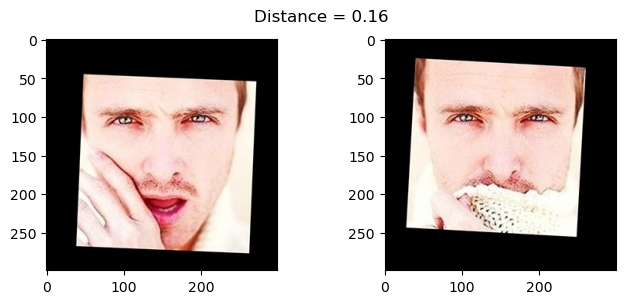

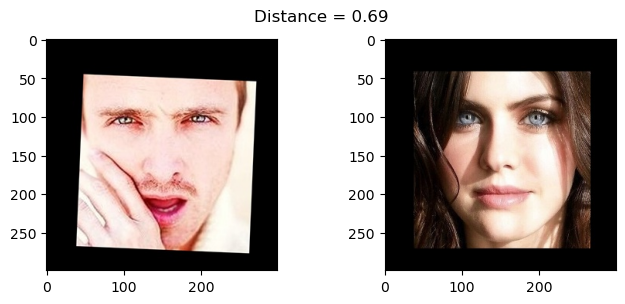

In [58]:
show_pair(2, 3)
show_pair(2, 180)

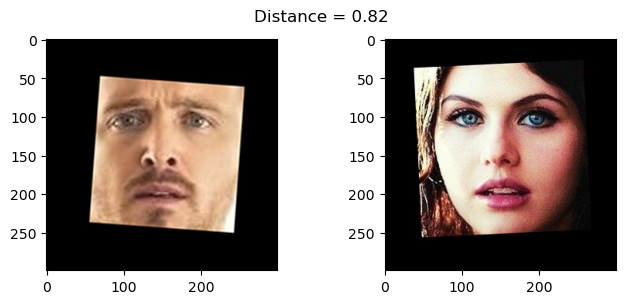

In [59]:
show_pair(10, 100)

In [61]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

X_train_c = np.array(embeddings)[train_idx]
X_test_c = np.array(embeddings)[test_idx]

y_train_c = np.array([meta.name for meta in metadata[train_idx]])
y_test_c = np.array([meta.name for meta in metadata[test_idx]])

display(X_train_c.shape, X_test_c.shape, y_train_c.shape, y_test_c.shape)

(9573, 2622)

(1197, 2622)

(9573,)

(1197,)

Encode the Labels
Encode the labels
Use LabelEncoder

In [62]:
le = LabelEncoder()
y_train_c = le.fit_transform(y_train_c)
y_test_c = le.transform(y_test_c)

Standardize the feature values
Scale the features using StandardScaler

In [63]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train_c)
X_test_sc = sc.transform(X_test_c)

Use PCA for dimensionality reduction

In [64]:
cov_matrix = np.cov(X_train_sc.T)

In [65]:
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

In [66]:
tot = sum(eig_vals)
var_exp = [(i /tot) * 100 for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

print('Cumulative Variance Explained', cum_var_exp)

Cumulative Variance Explained [ 13.58416795  18.94867841  22.94242516 ...  99.99999983  99.99999999
 100.        ]


In [67]:
threshold = 90
r = list(filter(lambda i: i > threshold, cum_var_exp))[0]
index = (cum_var_exp.tolist().index(r))
print(f'Index of element just greater than {threshold}: {str(index)}')

Index of element just greater than 90: 180


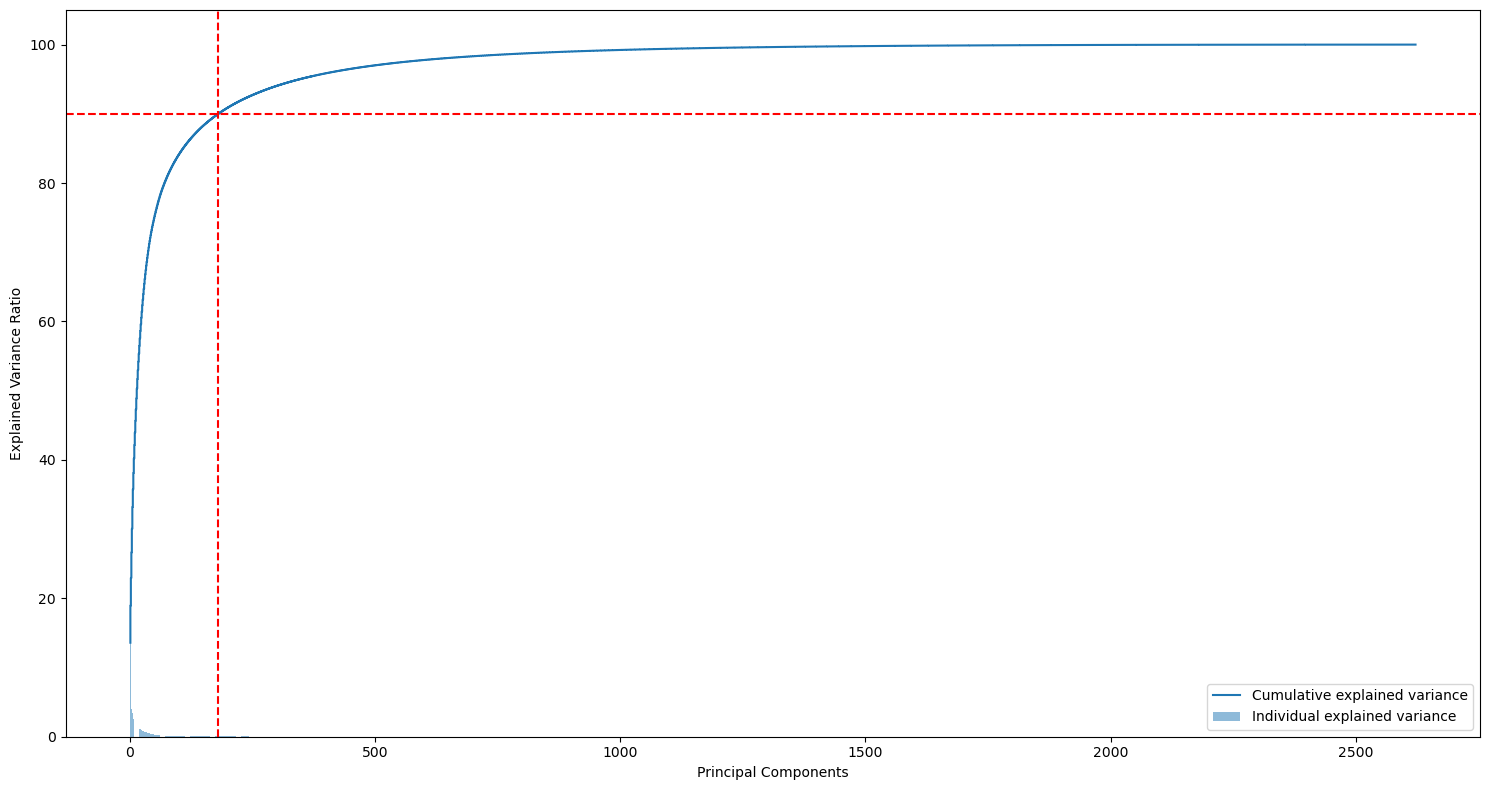

In [68]:
# Ploting 
plt.figure(figsize = (15 , 8))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, label = 'Cumulative explained variance')
plt.axhline(y = threshold, color = 'r', linestyle = '--')
plt.axvline(x = index, color = 'r', linestyle = '--')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [69]:
# Reducing the dimensions
pca = PCA(n_components = index, random_state = 42, svd_solver = 'full', whiten = True)
pca.fit(X_train_sc)
X_train_pca = pca.transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
display(X_train_pca.shape, X_test_pca.shape)

(9573, 180)

(1197, 180)

Build an SVM classifier in order to map each image to its right person

In [82]:
svc = SVC(C = 1, gamma = 0.0001, kernel = 'rbf', class_weight = 'balanced', random_state = 42)
svc.fit(X_train_pca, y_train_c)
print('Accuracy for train set: ',str(svc.score(X_train_pca, y_train_c)))

Accuracy for train set:  0.9422333646714719


In [83]:
y_pred_c = svc.predict(X_test_pca)

print('Accuracy for test set: ', str(accuracy_score(y_test_c, y_pred_c)))

Accuracy for test set:  0.9239766081871345


In [84]:
print('Classification Report: \n{}'.format(classification_report(y_test_c, y_pred_c, target_names = np.unique(labelsc))))

Classification Report: 
                               precision    recall  f1-score   support

              pins_Aaron Paul       1.00      1.00      1.00        10
            pins_Alvaro Morte       1.00      1.00      1.00        10
             pins_Amanda Crew       1.00      1.00      1.00        14
          pins_Amaury Nolasco       1.00      1.00      1.00        12
               pins_Anna Gunn       1.00      1.00      1.00         7
    pins_Benedict Cumberbatch       1.00      0.89      0.94         9
            pins_Betsy Brandt       1.00      0.86      0.92         7
        pins_Brenton Thwaites       1.00      1.00      1.00        14
            pins_Brit Marling       1.00      0.93      0.96        14
          pins_Bryan Cranston       1.00      1.00      1.00         9
              pins_Caity Lotz       0.92      0.86      0.89        14
        pins_Cameron Monaghan       0.92      0.92      0.92        12
          pins_Chance Perdomo       1.00      1.00  

Import and display the the test images

In [85]:
bc_img = cv2.imread('BenedictCumberbatch.jpg')

In [86]:
dj_img = cv2.imread('DwayneJohnson.jpg')

Use the trained SVM model to predict the face on both test images

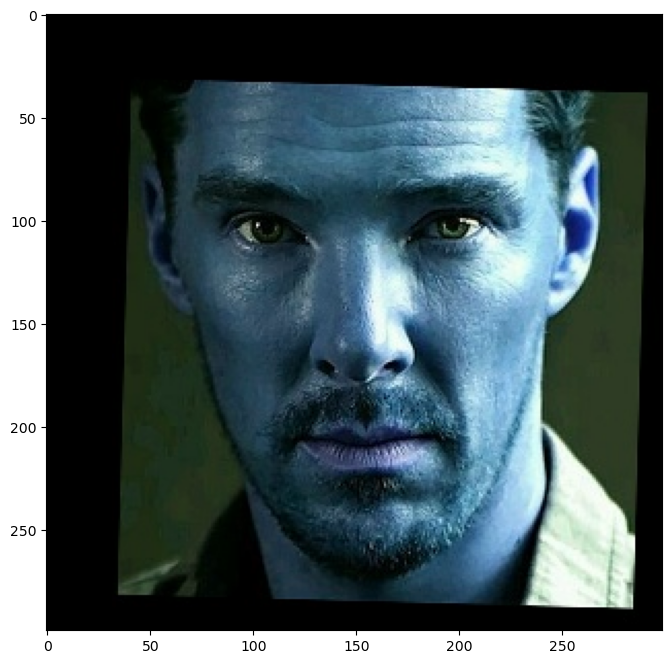

In [87]:
fig = plt.figure(figsize = (12, 8))
plt.imshow(bc_img)
plt.show()

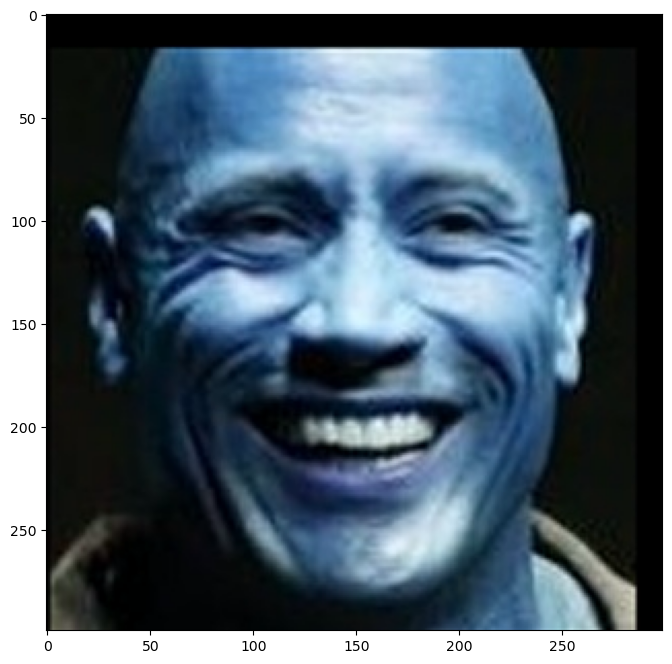

In [88]:
fig = plt.figure(figsize = (12, 8))
plt.imshow(dj_img)
plt.show()

In [89]:
bc_img = (bc_img/255.).astype(np.float32)
bc_img = cv2.resize(bc_img, (224, 224))
embedding1 = vgg_face_descriptor.predict(np.expand_dims(bc_img, axis = 0))[0]
embedding_scaled1 = sc.transform(embedding1.reshape(1, -1))
sample_pred1 = svc.predict(pca.transform(embedding_scaled1))
pred_name1 = le.inverse_transform(sample_pred1)[0].split('_')[-1].title().strip()
print(pred_name1)

1/1 [==============================] - 0s 329ms/step
Benedict Cumberbatch


In [90]:
dj_img = (bc_img/255.).astype(np.float32)
dj_img = cv2.resize(dj_img, (224, 224))
embedding2 = vgg_face_descriptor.predict(np.expand_dims(dj_img, axis = 0))[0]
embedding_scaled2 = sc.transform(embedding2.reshape(1, -1))
sample_pred2 = svc.predict(pca.transform(embedding_scaled2))
pred_name2 = le.inverse_transform(sample_pred2)[0].split('_')[-1].title().strip()
print(pred_name2)

1/1 [==============================] - 0s 345ms/step
Pedro Alonso
